<center>
    <h1> Extended Project Supplement</h1>
</center>

Interactive plots + animations corresponding to figures
- Code for all figures??
- Numerical Methods 
- Application to model
- Space homogeneity
- Space inhomogeneity
- Python .py file too?


In [17]:
import numpy as np
from numpy.random import normal, uniform
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
cmap = plt.get_cmap('plasma')


from src import herding as herd
from src import SpaceHet as het
from src import SpaceHom as hom
from src import ToyProblems as TP
from src.plotting import hom_plot as homplt

savepath = './Report/Figures/'
save = False

## Toy Problems

- Heat eqn, adv eqn
- Mesh refinement error
- OU particles

### Heat Equation

Solving the heat equation using finite differences. To see the sensitivity of FTCS on mesh size, try violating the stability condition $\frac{\sigma \Delta t}{\Delta x}^2 < \frac{1}{2}$. For example, set `diffusion = 1, timestep = 0.01, spacestep = 0.1`

In [ ]:
%matplotlib inline
diffusion = 1
timestep = 0.005
spacestep = 0.1
T_final = 5
domain_size = 5
def indicator(x): return np.array([int(i>=-1 and i<=0) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=0, scale=1)

initial_data = gaussian
diff_solvers = [TP.FTCS, TP.BTCS, TP.CN]

###############################################################################
fig, ax = plt.subplots(len(diff_solvers), 1, figsize=(10,10))
#fig.suptitle('Heat Equation in 1D', fontsize=16)

if len(diff_solvers)==1:
    ax = [ax]

for idx, solver in enumerate(diff_solvers):
    x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                            T_end=T_final, L=domain_size, initial_dist=initial_data)
    homplt.static_line(x, sol, solver, ax[idx])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

if save:
    plt.savefig(savepath+'{}.eps'.format(timestep), format='eps', dpi=1000)

### Advection Equation

Solving the advection equation using finite differences and finite volumes. Both methods are sensitive to mesh spacing. For example, set `wavespeed = 1, timestep = 0.21, spacestep = 0.1`. Also note the artificial dispersion introduced, regardless of spacing.

In [ ]:
wavespeed = 0.5
T_final = 3
timestep = 0.01
spacestep = 0.1
domain_size = 5 
def indicator(x): return np.array([int(i>=-1 and i<=0) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=0, scale=1)
initial_data = indicator
adv_solvers = [TP.upwind, TP.FV_upwind]


###############################################################################
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
#fig.suptitle('Advection Equation in 1D', fontsize=16)
cmap = plt.get_cmap('plasma')
if len(adv_solvers)==1:
    ax = [ax]
for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = TP.solve_adv_eqn(solver=solver, a=wavespeed,
                                      dt=timestep, dx=spacestep,
                                      T_end=T_final, L=domain_size,
                                      initial_dist=initial_data)
    homplt.static_line(adv_x, adv_sol, solver, ax[idx])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save:
    plt.savefig(savepath+'adv'+initial_data.__name__+'.eps', format='eps', dpi=1000)

### Particle System with Langevin Dynamics


Outputs an animation of histogram of particles at each timestep. Along with the mean velocity and variance of all particles at each timestep.

In [ ]:
%matplotlib qt
particle_count = 1000
diffusion = 1
initial_data = uniform(low=2, high=4, size=particle_count)
timestep = 0.01
T_final = 5

animate = True
#If animation is too slow, increase framestep.
framestep = 1
###############################################################################
t, x, [m1, var] = TP.run_OU_process(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final)
ani = homplt.anim_hist_moments(t, x, m1, var, mu=0,
                               D=diffusion, fs=framestep, animate=animate)
plt.show()

Plot histogram of positions and 5 sample paths

In [ ]:
%matplotlib inline
T_final = 100

###############################################################################
t, x, [m1, var] = TP.run_OU_process(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final)

fig, ax = plt.subplots(1,2, figsize=(16,8))
n_x, bins_x, patches_x = ax[0].hist(x[-750:].flatten(),
                                    bins=np.arange(x.min(), x.max(), 0.15),
                                    density=True, label='Position')

mu = 0
D = 1
sigma = np.sqrt(D)
_x = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
stat_dist = stats.norm.pdf(_x, mu, sigma)

ax[0].plot(_x, stat_dist, 'r--')
ax[0].set_xlabel('Position', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
for _ in range(3):
    ax[1].plot(t[:500], x[:500,_], label='Particle {}'.format(_+1))
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_ylabel('Position', fontsize=18)
fig.show()
if save:
    fig.savefig(savepath+'OUparticletraj.eps', format='eps', dpi=1000)


# Space Homogeneous System

## Particle Model Simulation

OU process is same as space homogeneous with no interaction. Combine Interaction, histograms 


In [ ]:
%matplotlib qt
particle_count = 1000
diffusion = 1
initial_data = uniform(low=-2, high=1, size=particle_count)
timestep = 0.01
T_final = 50
herding_function = herd.smooth_G

framestep = 5
animate = True

t, v, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)

n, bins, patches = plt.hist(v[-500:].flatten(), bins=np.arange(v.min(), v.max(), 0.15),
                           density=True, label='Velocity')
stat_mu = np.sign(v[0,].mean())
stat_sigma = np.sqrt(diffusion)
_v = np.arange(stat_mu - 5*stat_sigma, stat_mu + 5*stat_sigma, 0.01)
stat_dist = stats.norm.pdf(_v, stat_mu, stat_sigma)

plt.plot(_v, stat_dist, '-.',label=r'Stationary D$^{\mathrm{n}}$')
plt.show()


ani = homplt.anim_hist_moments(t, v, M1, var, mu=stat_mu,
                               D=diffusion, fs=framestep, animate=animate)
plt.show()

## Kinetic Model

- Long time L1 error, asymmetry
- FV method
- agreement in histogram, visual with FD
- symmetric error
- Mesh refinement errors

Use the function below to see the convergence in moments for the finite difference method compared to the particle system, as well as an animation (if `animation = True`) of the solution evolving in time.

In [22]:
%matplotlib qt
diffusion = 1
particle_count = 1000
timestep = 0.01
T_final = 10
domain_size = 8
spacestep = 0.1

herding_function = herd.smooth_G
#Set initial data for Gaussian
mu_init = -2
sd_init = np.sqrt(2)

#Set max/min for indicator
max_init = 0
min_init = -1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data = gaussian #Choose indicator or Gaussian

framestep = 5
animate = True

###############################################################################
v, F, moments = hom.FD_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

t, traj, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data['particle'],
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)
if animate:
    ani = homplt.animate_PDE_hist(t, v, traj , F)
    plt.show()

fig,ax=plt.subplots()
ax.plot(t[1:], M1, label='Particle Mean')
ax.plot(t[1:], var, label='Particle Variance')
stat_mu = np.sign(traj[0,].mean())
ax.plot([0, T_final], [stat_mu, stat_mu], 'b-.')
ax.plot([0, T_final], [diffusion, diffusion], 'r:')
ax.plot(t[1:], moments[1], label='PDE Mean')
ax.plot(t[1:], moments[2]-moments[1]**2, label=' PDE Variance')

ax.set_xlabel('Time')
ax.legend(loc='best')
fig.show()

Finite difference mass loss was 0.00%


Rather than the eyeball metric, we can quantify the error in the stationary distribution for different discretisations below. The first cell gives the L^1 error, the second shows how time step and space step affect accuracy

Finite difference mass loss was 0.00%
Finite volume mass loss was -0.00%


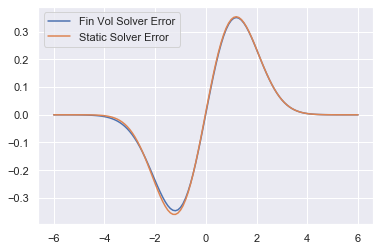

In [23]:
%matplotlib inline
diffusion = 1
timestep = 0.001
T_final = 10
domain_size = 6
spacestep = 0.1
particle_count = 100
herding_function = herd.smooth_G
#Set initial data for Gaussian
mu_init = -1.5
sd_init = 0.5

#Set max/min for indicator
max_init = 0
min_init = -1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data = gaussian #Choose indicator or Gaussian


v, F_diff, moments_diff = hom.FD_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

v, F_vol, moments_vol = hom.FV_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

stat_mu = np.sign(F_diff[0,].mean())
stat_dist = stats.norm.pdf(v, stat_mu, np.sqrt(diffusion))
plt.plot(v, stat_dist - F_vol[-1,], label='Fin Vol Solver Error')
plt.plot(v, stat_dist - F_diff[-1,], label='Static Solver Error')

plt.legend()
plt.show()

In [ ]:
diffusion = 1
timestep = 0.001
T_final = 10
domain_size = 6
spacestep = 0.1
particle_count = 100
herding_function = herd.smooth_G
#Set initial data for Gaussian
mu_init = -1.5
sd_init = 0.5

#Set max/min for indicator
max_init = 0
min_init = -1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data = gaussian #Choose indicator or Gaussian


timesteps = np.logspace(-3,-4,2)
print(timesteps)
error = np.zeros((2,len(timesteps)))
for idx, t in enumerate(timesteps):
    v, F_diff, moments_diff = hom.FD_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=t, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

    v, F_vol, moments_vol = hom.FV_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=t, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)
    error[:,idx] = np.array([(spacestep/(2*domain_size))*abs(stat_dist - F_vol[-1,]).sum(),
                    (spacestep/(2*domain_size))*abs(stat_dist - F_diff[-1,]).sum()])
    print(error)

plt.plot(timesteps, error[0,])
plt.plot(timesteps, error[1,])
plt.show()

[0.001  0.0001]
Finite difference mass loss was 0.00%


If the system is ran for a long time with a low number of particles, we see switches in stability and convergence to a distribution with mean zero.

In [21]:
%matplotlib qt
particle_count = 6
diffusion = 1
initial_data = uniform(low=-2, high=1, size=particle_count)
timestep = 0.01
T_final = 500
herding_function = herd.smooth_G

framestep = 50
animate = True

t, v, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)
stat_mu = np.sign(v[0,].mean())
stat_sigma = np.sqrt(diffusion)
_v = np.arange(stat_mu - 5*stat_sigma, stat_mu + 5*stat_sigma, 0.01)
stat_dist = stats.norm.pdf(_v, stat_mu, stat_sigma)

ani = homplt.anim_hist_moments(t, v, M1, var, mu=stat_mu, D=diffusion,
                               fs=framestep, animate=animate, timeavg=True)
plt.show()

C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

## Space Het Particle Model


In [ ]:
t, x, v = het.run_particle_model(particle_count=100, D=1,
                          initial_dist_x=np.pi/2,
                          initial_dist_v=uniform(low=0, high=1, size=100),
                          dt=0.01, T_end=200, G=herd.step_G)

g = sns.jointplot(x_1.flatten(), v_1.flatten(), kind="hex", height=7, space=0)